### Data reading and inspection

Let's load the required libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_colwidth", 200)

In this article, we will use 20 Newsgroup dataset from sklearn. You can read more about the dataset over [here]("http://qwone.com/~jason/20Newsgroups/).

In [2]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
len(documents)

11314

In [3]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

The dataset has 11,314 text documents distributed across 20 different newsgroups.

### Data Preprocessing

to start with, we will try to clean our text data as much as possible. We will remove the punctuations, numbers, special characters all in one step using the regex replace("[^a-zA-Z#]", " ") which will replace everything, except alphabets, with a space. Then we will remove shorter words because usually they don't contain much of the information. Finally we will make all the text lowercase to nullify case sensitivity.  

In [4]:
news_df = pd.DataFrame({'document':documents})

# removing everything except alphabets`
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z#]", " ")

# removing short words
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

It is a good practice to remove the stop-words from the text data as they are mostly clutter and hardly add carry any information. Stop-words are terms like 'it', 'they', 'am', 'been', 'about', 'because', 'while', etc. To remove the stop-words from the documents text we will have to tokenize the text, i.e., splitting the string of text into individual tokens or words. We will stitch the tokens back together once we have removed the stop-words

In [5]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# tokenization
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split()) 

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization
detokenized_doc = []
for i in range(len(news_df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)
    
news_df['clean_doc'] = detokenized_doc    

### Document-Term Matrix 

This is the first step towards topic modeling. We will use sklearn's TfidfVectorizer to create a document-term matrix with 1000 terms. 

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', 
                             max_features= 1000, # keep top 1000 terms 
                             max_df = 0.5, 
                             smooth_idf=True)

X = vectorizer.fit_transform(news_df['clean_doc'])

X.shape # check shape of the document-term matrix

(11314, 1000)

We could have used all the terms to create this matrix but that would need quite a lot of computation. Hence, we have restricted the number of features to 1000.

## Topic Modeling

The next step is to represent each and every term and document as a vector. We will use the document-term matrix and decompose it into multiple matrices. We will use sklearn's TruncatedSVD to perform the task of matrix decomposition. Since the data comes from 20 different newsgroups, let's try to have 20 topics for our text data. The number of topics can be specified by using the *n_components* parameter. 

In [7]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

20

The components of svd_model are our topics and we can access them using svd_model.components_. Finally let's print a few most important words in each of the 20 topics and see how our model has done.

In [8]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
    print(" ")

Topic 0: 
like
know
people
think
good
time
thanks
 
Topic 1: 
thanks
windows
card
drive
mail
file
advance
 
Topic 2: 
game
team
year
games
season
players
good
 
Topic 3: 
drive
scsi
disk
hard
card
drives
problem
 
Topic 4: 
windows
file
window
files
program
using
problem
 
Topic 5: 
government
chip
mail
space
information
encryption
data
 
Topic 6: 
like
bike
know
chip
sounds
looks
look
 
Topic 7: 
card
sale
video
offer
monitor
price
jesus
 
Topic 8: 
know
card
chip
video
government
people
clipper
 
Topic 9: 
good
know
time
bike
jesus
problem
work
 
Topic 10: 
think
chip
good
thanks
clipper
need
encryption
 
Topic 11: 
thanks
right
problem
good
bike
time
window
 
Topic 12: 
good
people
windows
know
file
sale
files
 
Topic 13: 
space
think
know
nasa
problem
year
israel
 
Topic 14: 
space
good
card
people
time
nasa
thanks
 
Topic 15: 
people
problem
window
time
game
want
bike
 
Topic 16: 
time
bike
right
windows
file
need
really
 
Topic 17: 
time
problem
file
think
israel
long
mail
 
Topi

## Topics Visualization 

To find out how distinct our topics are we should visualize them. Of course we cannot visualize more than 3 dimensions, but there are techniques like PCA and t-SNE which can help us visualize high dimensional data into lower dimensions. Here we will use a relatively new technique called UMAP (Uniform Manifold Approximation and Projection).

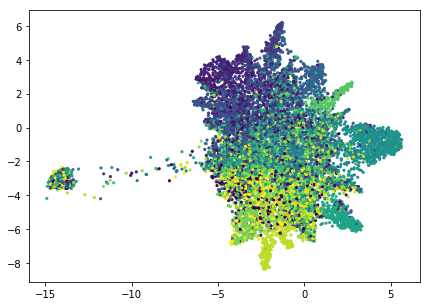

In [9]:
import umap

X_topics = svd_model.fit_transform(X)
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1],  
            c = dataset.target,
            s = 10, # size
            edgecolor='none'
            )
plt.show()